# Sephora Product Recommendation System

**Objective:** Increase sales and customer engagement by providing personalized product recommendations.

### Problem:

Sephora wants to boost sales and enhance customer satisfaction by offering personalized product recommendations. They have noticed that users are more likely to make additional purchases when they see recommendations tailored to their preferences. Currently, Sephora has detailed data on product attributes and user reviews, but they need an effective recommendation system to leverage this data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

np.random.seed(11)
sns.set()

## Product Data Exploration

In [2]:
product_info = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/product_info.csv')

product_info.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [3]:
product_info.shape, product_info.size

((8494, 27), 229338)

In [4]:
product_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [5]:
product_info.describe()

,brand_id,loves_count,rating,reviews,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price
count,8494.000000,8.494000e+03,8216.000000,8216.000000,8494.000000,451.000000,270.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,2754.000000,2754.000000
mean,5422.440546,2.917957e+04,4.194513,448.545521,51.655595,91.168537,20.207889,0.070285,0.071698,0.219096,0.073699,0.279374,1.631622,53.792023,39.665802
std,1709.595957,6.609212e+04,0.516694,1101.982529,53.669234,79.195631,24.327352,0.255642,0.258002,0.413658,0.261296,0.448718,5.379470,58.765894,38.685720
min,1063.000000,0.000000e+00,1.000000,1.000000,3.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,5333.000000,3.758000e+03,3.981725,26.000000,25.000000,45.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,19.000000
50%,6157.500000,9.880000e+03,4.289350,122.000000,35.000000,67.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,28.000000
75%,6328.000000,2.684125e+04,4.530525,418.000000,58.000000,108.500000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,59.000000,42.000000
max,8020.000000,1.401068e+06,5.000000,21281.000000,1900.000000,617.000000,320.000000,1.000000,1.000000,1.000000,1.000000,1.000000,105.000000,570.000000,400.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


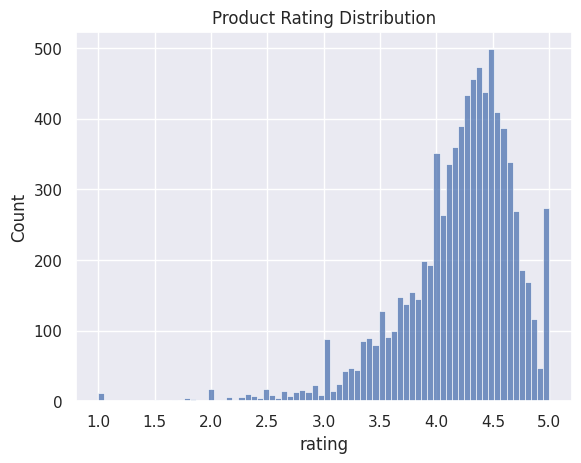

In [81]:
sns.histplot(data=product_info, x='rating')
plt.title('Product Rating Distribution')
plt.savefig('Product Rating Distribution.png')
plt.show()

### Average Rating Distribution

- Most products have a healthy average rating, with majority of ratings falling between 3 and 5
- A few products have really low ratings though

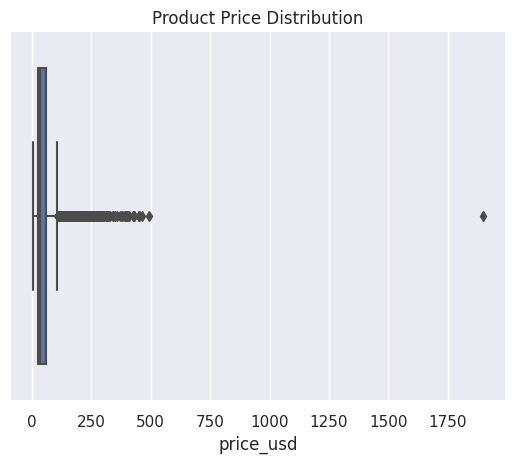

In [82]:
sns.boxplot(data=product_info, x='price_usd')
plt.title('Product Price Distribution')
plt.savefig('Product Price Distribution.png')
plt.show()

### Price Distribution

- Most of the products are very affordable, ranging from 25 Dollars to about 58 Dollars
- There are quite a few expensive products (outliers) however, with the most expensive product costing 1900 Dollars.

In [8]:
top_ten_most_loved = product_info[['product_id', 'product_name', 'loves_count', 'rating', 'price_usd']].sort_values('loves_count', ascending=False)[:10]

In [9]:
top_ten_most_loved

,product_id,product_name,loves_count,rating,price_usd
6242,P97989778,Soft Pinch Liquid Blush,1401068,4.5356,23.0
5249,P377873,Radiant Creamy Concealer,1153594,4.3080,32.0
4431,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,1081315,4.3508,24.0
6434,P281411,Cream Lip Stain Liquid Lipstick,1029051,4.3201,15.0
2523,P67988453,Gloss Bomb Universal Lip Luminizer,968317,4.6357,21.0
2524,P87985432,Pro Filt’r Soft Matte Longwear Liquid Foundation,856497,4.0356,40.0
5250,P2855,Blush,840076,4.6643,32.0
247,P202633,Brow Wiz Ultra-Slim Precision Brow Pencil,834189,4.4056,25.0
4458,P109908,Translucent Loose Setting Powder,813497,4.5029,43.0
7648,P427417,Niacinamide 10% + Zinc 1% Oil Control Serum,763168,4.2439,6.0


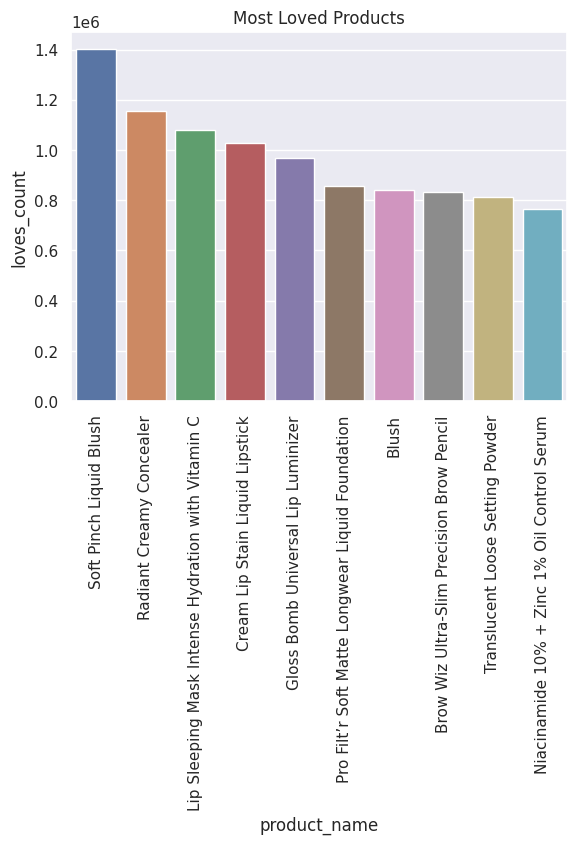

In [83]:
sns.barplot(data=top_ten_most_loved, x='product_name', y='loves_count')
plt.xticks(rotation=90)
plt.title('Most Loved Products')
plt.savefig('Most Loved Products.png')
plt.show()

### Most Loved Products

- The 'Soft Pinch Liquid Blush' is the most loved product in Sephora's inventory
- Followed by 'Radiant Creamy Concealer', 'Lip Sleeping Mask Intense Hydration with Vitamin C', 'Cream Lip Stain Liquid Lipstick' and the 'Gloss Bomb Universal Lip Luminizer'.

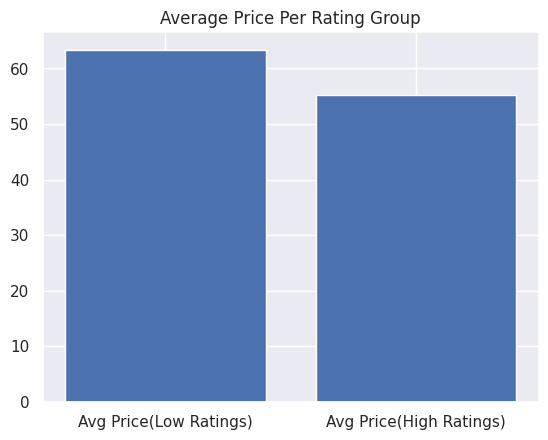

In [84]:
avg_price_lowest_ratings = product_info[['product_name', 'rating', 'price_usd']].sort_values('rating')[:20]['price_usd'].mean()
avg_price_highest_ratings = product_info[['product_name', 'rating', 'price_usd']].sort_values('rating', ascending=False)[:20]['price_usd'].mean()

plt.bar(x=['Avg Price(Low Ratings)', 'Avg Price(High Ratings)'], height=[avg_price_lowest_ratings, avg_price_highest_ratings])
plt.title('Average Price Per Rating Group')
plt.savefig('Average Price Per Rating Group.png')
plt.show()

### Average Price for Top 20 highest/lowest rated products

- On average, the products with the top 20 highest ratings cost less than the products with the top 20 lowest ratings.

In [12]:
product_info.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


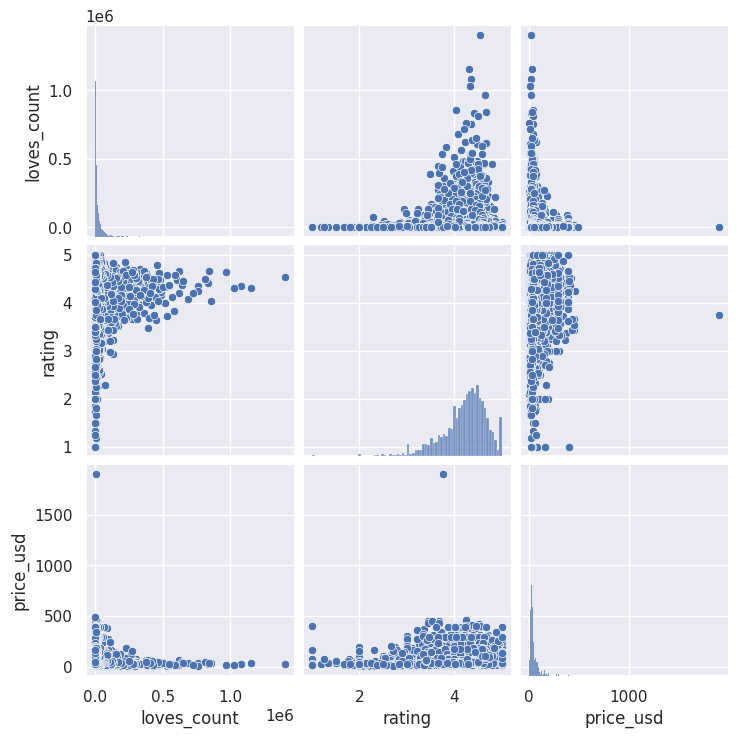

In [13]:
sns.pairplot(product_info[['loves_count','rating', 'price_usd']])
plt.show()

In [14]:
product_info.describe(exclude='number')

,product_id,product_name,brand_name,size,variation_type,variation_value,variation_desc,ingredients,highlights,primary_category,secondary_category,tertiary_category
count,8494,8494,8494,6863,7050,6896,1250,7549,6287,8494,8486,7504
unique,8494,8415,304,2055,7,2729,935,6538,4417,9,41,118
top,P473671,Fragrance Discovery Set,SEPHORA COLLECTION,1.7 oz/ 50 mL,Size,1.7 oz/ 50 mL,black,"['Sugarcane Alcohol Denat., Fragrance/Parfum*,...","['Layerable Scent', 'Floral Scent']",Skincare,Women,Perfume
freq,1,3,352,500,4043,374,46,15,64,2420,875,568


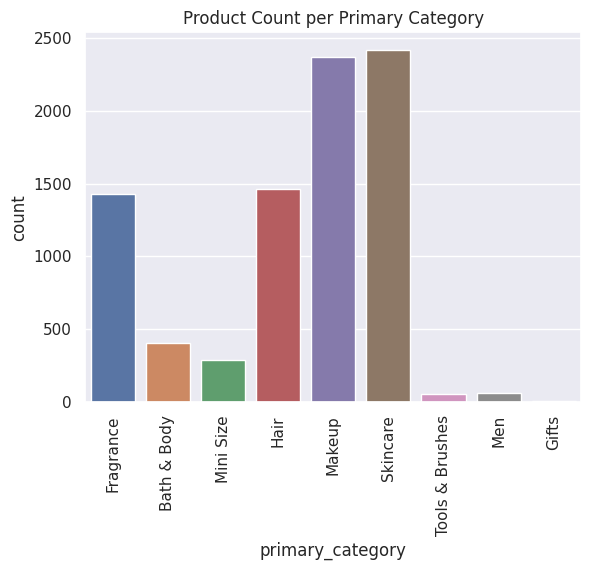

In [85]:
sns.countplot(data=product_info, x='primary_category')
plt.xticks(rotation=90)
plt.title('Product Count per Primary Category')
plt.savefig('Product Count per Primary Category.png')
plt.show()

### Product Count

- 'Skincare' and 'Makeup' are the most represented category, among the products
- 'Gifts' are the least represented category, followed by 'Men' and 'Tools & Brushes'.

In [16]:
most_common_brand = product_info['brand_name'].value_counts().reset_index().sort_values('count', ascending=False)

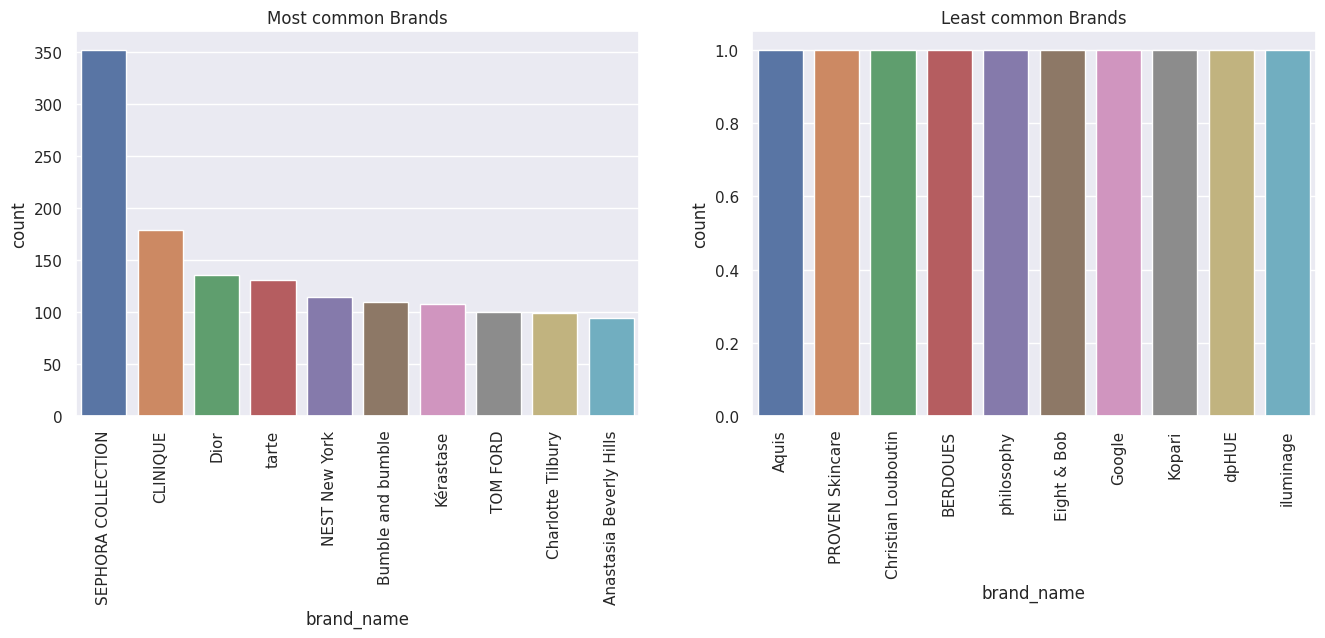

In [86]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

sns.barplot(data=most_common_brand[:10], x='brand_name', y='count',ax=ax1)
for label in ax1.get_xticklabels():
    label.set_rotation(90)
ax1.set_title('Most common Brands')

sns.barplot(data=most_common_brand[-10:], x='brand_name', y='count',ax=ax2)
for label in ax2.get_xticklabels():
    label.set_rotation(90)
ax2.set_title('Least common Brands')

plt.savefig('Brand Product Frequency.png')
plt.show()

### Most/Least Common Brand

- 'Sephora Collection' products are the most common in our product gallery
- 'Clinique', 'Dior', 'tarte' and 'NEST New York' round up the top 5
- The least represented brands in our collection all have just 1 product.

## Reviews Data Exploration

In [18]:
reviews_1 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_0-250.csv', parse_dates=['submission_time'])
reviews_2 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_250-500.csv', parse_dates=['submission_time'])
reviews_3 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_500-750.csv', parse_dates=['submission_time'])
reviews_4 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_750-1250.csv', parse_dates=['submission_time'])
reviews_5 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_1250-end.csv', parse_dates=['submission_time'])

/tmp/ipykernel_833/3093124720.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_1 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_0-250.csv', parse_dates=['submission_time'])
/tmp/ipykernel_833/3093124720.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_4 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_750-1250.csv', parse_dates=['submission_time'])
/tmp/ipykernel_833/3093124720.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_5 = pd.read_csv('/kaggle/input/sephora-products-and-skincare-reviews/reviews_1250-end.csv', parse_dates=['submission_time'])


In [19]:
reviews = pd.concat([reviews_1, reviews_2, reviews_3, reviews_4, reviews_5])

In [20]:
del reviews_1, reviews_2, reviews_3, reviews_4, reviews_5

In [21]:
reviews.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [22]:
reviews.columns

Index(['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')

In [23]:
reviews.drop(['Unnamed: 0', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 
       'review_title'], axis=1, inplace=True)

In [24]:
reviews.head()

,author_id,rating,submission_time,review_text,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,1741593524,5,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1,2023-03-21,I bought this lip mask after reading the revie...,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5,2023-03-21,My review title says it all! I get so excited ...,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5,2023-03-20,I’ve always loved this formula for a long time...,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5,2023-03-20,"If you have dry cracked lips, this is a must h...",light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [25]:
print(reviews.shape, reviews.size)

(1094411, 12) 13132932


In [26]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1094411 entries, 0 to 49976
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   author_id        1094411 non-null  object        
 1   rating           1094411 non-null  int64         
 2   submission_time  1094411 non-null  datetime64[ns]
 3   review_text      1092967 non-null  object        
 4   skin_tone        923872 non-null   object        
 5   eye_color        884783 non-null   object        
 6   skin_type        982854 non-null   object        
 7   hair_color       867643 non-null   object        
 8   product_id       1094411 non-null  object        
 9   product_name     1094411 non-null  object        
 10  brand_name       1094411 non-null  object        
 11  price_usd        1094411 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 108.5+ MB


In [27]:
reviews.describe(include='all').round(1)

,author_id,rating,submission_time,review_text,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
count,1094411,1094411.0,1094411,1092967,923872,884783,982854,867643,1094411,1094411,1094411,1094411.0
unique,578653,NaN,NaN,969419,14,6,4,7,2351,2334,142,NaN
top,1696370280,NaN,NaN,I received this in a sample. I have alot of ac...,light,brown,combination,brown,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,CLINIQUE,NaN
freq,234,NaN,NaN,59,266418,471181,544513,403099,16138,16138,49029,NaN
mean,NaN,4.3,2019-10-22 12:07:39.508539392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0
min,NaN,1.0,2008-08-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
25%,NaN,4.0,2018-10-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
50%,NaN,5.0,2020-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
75%,NaN,5.0,2021-10-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0
max,NaN,5.0,2023-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900.0


In [28]:
reviews[reviews['brand_name'] == 'SEPHORA COLLECTION'].groupby(['product_id', 'product_name'])['rating'].agg('count').sort_values(ascending=False)[:50]

product_id  product_name                                           
P409800     Cleansing & Exfoliating Wipes                              3837
P442594     Ultra Glow Serum: Glow + Strengthen Vitamin C Serum        1493
P460855     Clean Lip Balm & Scrub                                      611
P438619     Brightening Eye Cream with Caffeine and Hyaluronic Acid     531
P460723     Clean Cleansing & Gentle Exfoliating Wipes                  524
P500744     Clean Lip Balm & Scrub                                      473
P438620     Nourishing Moisturizer with Prebiotics                      472
P442589     Instant Masks                                               455
P442535     Glow Peel Pads                                              452
P438617     All Day Hyaluronic Acid Hydrator Moisturizer                427
P438618     Clean Skin Gel Cleanser with Prebiotics                     424
P460701     Clean Face Mask                                             386
P460856     Clean Ey

In [29]:
brand_reviews_count = reviews['brand_name'].value_counts().reset_index()

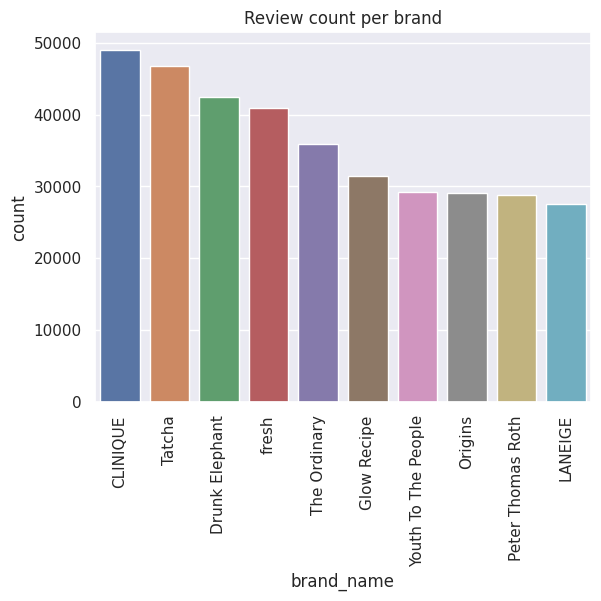

In [88]:
sns.barplot(data=brand_reviews_count[:10], x='brand_name', y='count')
plt.xticks(rotation=90)
plt.title('Review count per brand')
plt.savefig('Review count per brand.png')
plt.show()

Brand With The Most Reviews

- CLINIQUE products receive the most reviews
- Tatcha, Drunk Elephant, fresh and The Ordinary complete the top 5

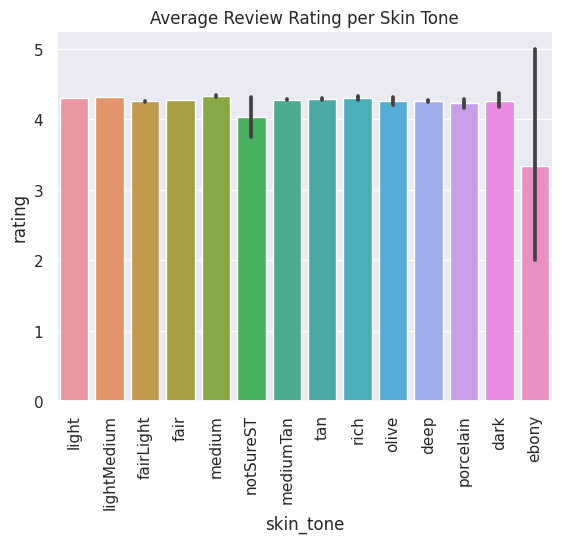

In [89]:
sns.barplot(data=reviews, x='skin_tone', y='rating')
plt.xticks(rotation=90)
plt.title('Average Review Rating per Skin Tone')
plt.savefig('Average Review Rating per Skin Tone.png')
plt.show()

### Average Rating based on Skintone

- Most skin tones average high average ratings
- People with 'ebony' skin tones on average are not as satisfied with the products. 
- Should consider adding more products tailored to 'ebony' skin

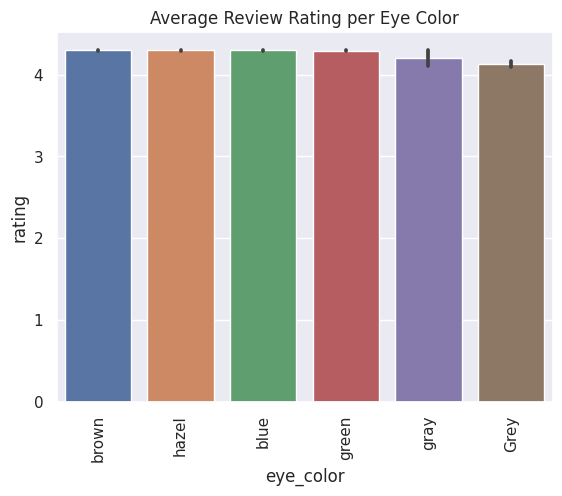

In [32]:
sns.barplot(data=reviews, x='eye_color', y='rating')
plt.xticks(rotation=90)
plt.title('Average Review Rating per Eye Color')
plt.show()

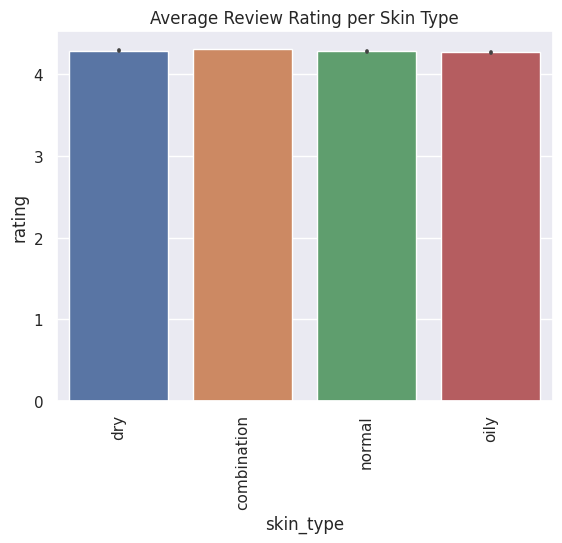

In [33]:
sns.barplot(data=reviews, x='skin_type', y='rating')
plt.xticks(rotation=90)
plt.title('Average Review Rating per Skin Type')
plt.show()

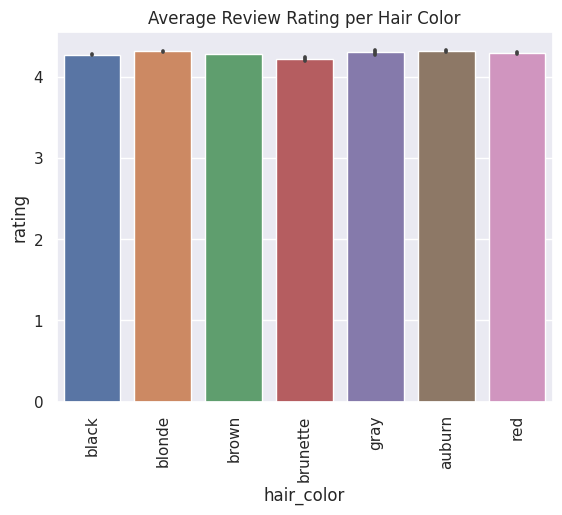

In [34]:
sns.barplot(data=reviews, x='hair_color', y='rating')
plt.xticks(rotation=90)
plt.title('Average Review Rating per Hair Color')
plt.show()

## Collaborative Filtering

In [35]:
rating_matrix = pd.pivot_table(reviews, values='rating', index='product_id', columns='author_id', fill_value=0)

In [36]:
rating_matrix.shape

(2351, 578653)

In [37]:
svd = TruncatedSVD(n_components=200)

In [38]:
ds = pd.DataFrame(svd.fit_transform(rating_matrix.values))

In [39]:
ds.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.487571,0.000485,0.354881,0.164250,0.305775,0.061963,-0.014153,0.003443,0.544049,0.282346,...,-0.298160,0.126458,0.035407,0.074374,0.109991,0.121589,-0.026209,-0.015501,0.023679,0.012695
1,1.143462,0.002892,1.327683,1.151278,2.580769,-0.373463,-0.186423,0.014930,2.472243,0.944078,...,12.696545,-2.183188,7.632121,0.598170,-4.794628,7.602623,-5.341593,-2.227096,-2.436764,0.400836
2,2.814835,0.001941,4.620068,3.825429,4.629557,0.782205,-0.371598,0.014177,4.312825,1.367499,...,2.266846,0.554645,1.813181,1.261958,-3.748234,2.212953,-0.311073,-4.462838,-1.490522,-0.799168
3,0.095728,0.000090,0.112047,0.263623,0.226477,-0.104420,-0.014470,0.001172,0.247011,0.155986,...,-0.008890,0.328892,-0.180934,-0.099241,-0.113404,0.095761,-0.059325,-0.096516,-0.139274,0.137949
4,0.438153,0.000875,0.597808,0.658644,1.899494,-0.505534,0.094047,0.005613,1.010802,1.008854,...,-1.837237,4.104622,-2.149565,-3.235992,2.317627,2.473472,-0.222685,-0.546323,-2.190941,2.272893


In [40]:
ds.index = rating_matrix.index

In [41]:
ds

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
product_id,,,,,,,,,,,,,,,,,,,,,
P107306,0.487571,0.000485,0.354881,0.164250,0.305775,0.061963,-0.014153,0.003443,0.544049,0.282346,...,-0.298160,0.126458,0.035407,0.074374,0.109991,0.121589,-0.026209,-0.015501,0.023679,0.012695
P114902,1.143462,0.002892,1.327683,1.151278,2.580769,-0.373463,-0.186423,0.014930,2.472243,0.944078,...,12.696545,-2.183188,7.632121,0.598170,-4.794628,7.602623,-5.341593,-2.227096,-2.436764,0.400836
P12045,2.814835,0.001941,4.620068,3.825429,4.629557,0.782205,-0.371598,0.014177,4.312825,1.367499,...,2.266846,0.554645,1.813181,1.261958,-3.748234,2.212953,-0.311073,-4.462838,-1.490522,-0.799168
P122651,0.095728,0.000090,0.112047,0.263623,0.226477,-0.104420,-0.014470,0.001172,0.247011,0.155986,...,-0.008890,0.328892,-0.180934,-0.099241,-0.113404,0.095761,-0.059325,-0.096516,-0.139274,0.137949
P122661,0.438153,0.000875,0.597808,0.658644,1.899494,-0.505534,0.094047,0.005613,1.010802,1.008854,...,-1.837237,4.104622,-2.149565,-3.235992,2.317627,2.473472,-0.222685,-0.546323,-2.190941,2.272893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P94421,0.007224,4.326808,0.009014,0.010965,0.022541,0.003319,-0.011501,6.050578,-0.003169,-0.027284,...,-0.059077,-0.017741,-0.167475,-0.339754,0.152462,-0.215590,-0.008878,0.008633,0.152634,-0.315622
P94812,0.278381,0.001102,0.714086,0.028018,0.703532,-0.236346,0.024006,0.004656,0.636983,0.416440,...,-0.539894,0.805915,0.198878,0.578996,0.786551,0.645569,0.247838,0.576982,0.006464,-0.302272
P9939,0.279944,0.000332,0.398461,0.148086,0.445271,0.109732,-0.121854,0.001886,0.445807,0.199996,...,-0.167387,0.006809,-0.099453,0.063070,0.019575,0.104445,-0.064679,0.049501,0.070702,-0.113999


In [42]:
nn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean', n_jobs=-1)

In [43]:
nn.fit(ds)

NearestNeighbors(algorithm='brute', metric='euclidean', n_jobs=-1,
                 n_neighbors=10)

In [44]:
def get_recommendations(prod_id):
    ratings_array = ds.loc[prod_id].to_numpy().reshape(1, -1)
    dist, ind = nn.kneighbors(ratings_array, n_neighbors=6)
    similar_products = ds.iloc[ind[0]].index
    
    products = product_info[(product_info['product_id'].isin(similar_products)) & (product_info['product_id'] != prod_id)][['product_name', 'price_usd', 'brand_name', 'rating', 'primary_category', 'secondary_category']]
    product = product_info[product_info['product_id'] == prod_id][['product_name', 'primary_category']].values
    return product, products

In [74]:
def format_products(prod_id):
    product, products = get_recommendations(prod_id)
    
    print(f"Users who liked the {product[0][1]} product: '{product[0][0]}' also purchased:")
    print("-" * 60)
    
    for index, row in products.iterrows():
        print(f"Product Name   : {row['product_name']}")
        print(f"Category       : {row['primary_category']}")
        print(f"Brand          : {row['brand_name']}")
        print(f"Price (USD)    : ${row['price_usd']:.2f}")
        print("-" * 60)

In [46]:
correlation_matrix = np.corrcoef(ds.values)

In [47]:
correlation_matrix.shape

(2351, 2351)

In [75]:
def cor_recommend_products(prod_id, ds, cor_mat):
    product_names = list(ds.index)
    product_ID = product_names.index(prod_id)
    product_ID
    
    correlation_product_ID = cor_mat[product_ID]
    correlation_product_ID.shape
    
    product_correlations = list(zip(ds.index[correlation_product_ID > 0.55], correlation_product_ID[correlation_product_ID > 0.55]))

    sorted_product_correlations = sorted(product_correlations, key=lambda x: x[1], reverse=True)
    recommend = list(p_id[0] for p_id in sorted_product_correlations)
    
    recommend.remove(prod_id) 
    
    products = product_info[(product_info['product_id'].isin(recommend[:5])) & (product_info['product_id'] != prod_id)][['product_name', 'price_usd', 'brand_name', 'rating', 'primary_category', 'secondary_category']]
    product = product_info[product_info['product_id'] == prod_id][['product_name', 'primary_category']].values
    
    print(f"Users who liked the {product[0][1]} product: '{product[0][0]}' also purchased:")
    print("-" * 60)
    
    for index, row in products.iterrows():
        print(f"Product Name   : {row['product_name']}")
        print(f"Category       : {row['primary_category']}")
        print(f"Brand          : {row['brand_name']}")
        print(f"Price (USD)    : ${row['price_usd']:.2f}")
        print("-" * 60)

In [77]:
cor_recommend_products('P483136', ds, correlation_matrix)

Users who liked the Skincare product: 'Targeted Anti-Aging Bakuchiol Serum' also purchased:
------------------------------------------------------------
Product Name   : Fruit-Tox Resurfacing Facial Remedy
Category       : Skincare
Brand          : Naturally Serious
Price (USD)    : $27.00
------------------------------------------------------------
Product Name   : Nourishing Moisturizer with Prebiotics
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $18.00
------------------------------------------------------------
Product Name   : Hydrating Serum
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $20.00
------------------------------------------------------------
Product Name   : Overnight Hydrating Mask
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $16.00
------------------------------------------------------------
Product Name   : Ultra Glow Toner with Vitamins C + E
Category       : Skinc

In [78]:
format_products('P483136')

Users who liked the Skincare product: 'Targeted Anti-Aging Bakuchiol Serum' also purchased:
------------------------------------------------------------
Product Name   : Dewy Glow Moisturizer with Cherry Blossom & Niacinamide
Category       : Skincare
Brand          : innisfree
Price (USD)    : $26.00
------------------------------------------------------------
Product Name   : Clarifying Spot Serum with Bija Seed Oil
Category       : Skincare
Brand          : innisfree
Price (USD)    : $18.00
------------------------------------------------------------
Product Name   : Fruit-Tox Resurfacing Facial Remedy
Category       : Skincare
Brand          : Naturally Serious
Price (USD)    : $27.00
------------------------------------------------------------
Product Name   : Ultra Glow Toner with Vitamins C + E
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $14.00
------------------------------------------------------------
Product Name   : (Re) Setting Refreshing

## Content-Based Filtering

In [53]:
copy = product_info.copy()

In [54]:
copy.loc[:, 'ingredients'] = copy['ingredients'].fillna('[]')

In [55]:
import re

pattern = r"[\'\[\]]"

copy.loc[:, 'ingredients'] = [re.sub(pattern, '', s) for s in copy['ingredients']]

In [56]:
vect = TfidfVectorizer(stop_words='english')

In [57]:
vect.fit(copy['ingredients'])

TfidfVectorizer(stop_words='english')

In [58]:
matrix = vect.transform(copy['ingredients'])

In [59]:
matrix = matrix.todense()

In [60]:
svd_two = TruncatedSVD(n_components=200)

In [61]:
word_matrix_ds = pd.DataFrame(svd_two.fit_transform(np.asarray(matrix)), index = product_info['product_id'])

In [62]:
word_matrix_ds

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
product_id,,,,,,,,,,,,,,,,,,,,,
P473671,0.286462,0.197620,0.599732,0.001097,-0.002771,-0.104692,0.019455,0.111842,-0.088685,0.027388,...,-0.022064,0.012218,-0.008935,-0.001294,-0.011851,0.014224,0.022846,-0.020164,-0.003976,0.028831
P473668,0.287495,0.210605,0.622248,0.010466,0.001258,-0.099454,0.006528,0.098366,-0.072812,-0.038883,...,-0.033421,0.006610,0.005203,-0.002129,0.003647,0.016928,0.034892,0.000639,-0.024181,0.037370
P473662,0.251767,0.193447,0.549040,0.014572,0.018883,-0.078311,0.001519,0.167210,-0.112900,0.004625,...,-0.009217,0.009420,-0.020581,-0.007113,-0.013211,0.004730,0.020502,-0.025654,-0.000260,0.014525
P473660,0.248495,0.187280,0.536250,0.012870,0.016944,-0.081644,0.009735,0.175309,-0.120250,0.023666,...,-0.008570,0.009102,-0.020453,-0.004095,-0.021326,-0.004216,-0.000301,-0.018394,-0.007798,0.003353
P473658,0.215912,0.158590,0.453250,0.001194,0.008548,-0.089372,0.005699,0.156000,-0.104674,0.042308,...,-0.017303,0.008027,-0.019756,-0.013683,-0.020374,0.011192,0.031941,-0.012358,0.002063,0.020271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P467659,0.377507,0.214381,-0.274590,-0.072712,0.036190,-0.133511,-0.039289,-0.108453,-0.140321,-0.121992,...,-0.010088,0.012637,-0.000855,-0.012932,0.041614,0.057065,-0.053027,-0.030740,0.050165,-0.016156
P500874,0.399657,0.434158,0.284819,0.032814,0.191016,0.223979,-0.003488,-0.003601,-0.004322,0.049107,...,0.005348,-0.009235,0.030990,0.010075,-0.003979,0.019011,0.011662,0.011219,-0.013040,0.013131
P504428,0.485017,0.110903,0.397139,0.212388,-0.033739,0.099453,-0.084200,0.074445,-0.135440,0.020918,...,0.079789,-0.005027,-0.012752,-0.041551,0.000054,-0.027440,0.016448,0.009844,0.008447,0.013700


In [63]:
nn_two = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean', n_jobs=-1)

In [64]:
nn_two.fit(word_matrix_ds)

NearestNeighbors(algorithm='brute', metric='euclidean', n_jobs=-1,
                 n_neighbors=10)

In [65]:
correlation_matrix_two = np.corrcoef(word_matrix_ds)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [66]:
correlation_matrix_two.shape

(8494, 8494)

In [67]:
def get_recommendations_two(prod_id):
    ratings_array = word_matrix_ds.loc[prod_id].to_numpy().reshape(1, -1)
    dist, ind = nn_two.kneighbors(ratings_array, n_neighbors=6)
    similar_products = word_matrix_ds.iloc[ind[0]].index
    
    products = product_info[(product_info['product_id'].isin(similar_products)) & (product_info['product_id'] != prod_id)][['product_name', 'price_usd', 'brand_name', 'rating', 'primary_category', 'secondary_category']]
    product = product_info[product_info['product_id'] == prod_id][['product_name', 'primary_category']].values
    return product, products

In [68]:
def format_products_two(prod_id):
    product, products = get_recommendations_two(prod_id)
    
    print(f"Since you like the {product[0][1]} product: '{product[0][0]}',")
    print("You might also like:")
    print("-" * 60)
    
    for index, row in products.iterrows():
        print(f"Product Name   : {row['product_name']}")
        print(f"Category       : {row['primary_category']}")
        print(f"Brand          : {row['brand_name']}")
        print(f"Price (USD)    : ${row['price_usd']:.2f}")
        print("-" * 60)

In [69]:
def cor_recommend_products_two(prod_id, my_ds, cor_mat):
    product_names = list(my_ds.index)
    product_ID = product_names.index(prod_id)
    product_ID
    
    correlation_product_ID = cor_mat[product_ID]
    correlation_product_ID.shape
    
    product_correlations = list(zip(my_ds.index[correlation_product_ID > 0.55], correlation_product_ID[correlation_product_ID > 0.55]))

    sorted_product_correlations = sorted(product_correlations, key=lambda x: x[1], reverse=True)
    recommend = list(p_id[0] for p_id in sorted_product_correlations)
    
    recommend.remove(prod_id)
    
    products = product_info[(product_info['product_id'].isin(recommend[:5])) & (product_info['product_id'] != prod_id)][['product_name', 'price_usd', 'brand_name', 'rating', 'primary_category', 'secondary_category']]
    product = product_info[product_info['product_id'] == prod_id][['product_name', 'primary_category']].values
    
    print(f"Since you like the {product[0][1]} product: '{product[0][0]}',")
    print("You might also like:")
    print("-" * 60)
    
    for index, row in products.iterrows():
        print(f"Product Name   : {row['product_name']}")
        print(f"Category       : {row['primary_category']}")
        print(f"Brand          : {row['brand_name']}")
        print(f"Price (USD)    : ${row['price_usd']:.2f}")
        print("-" * 60)

In [72]:
format_products_two('P483136')

Since you like the Skincare product: 'Targeted Anti-Aging Bakuchiol Serum',
You might also like:
------------------------------------------------------------
Product Name   : Premier Cru Anti-Aging Serum with Niacinamide and Hyaluronic Acid
Category       : Skincare
Brand          : Caudalie
Price (USD)    : $139.00
------------------------------------------------------------
Product Name   : Nourishing Moisturizer with Prebiotics
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $18.00
------------------------------------------------------------
Product Name   : Targeted Wrinkle Serum
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $20.00
------------------------------------------------------------
Product Name   : Best Sellers Set
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $20.00
------------------------------------------------------------
Product Name   : Bakuchiol Retinol Alternative Moi

In [73]:
cor_recommend_products_two('P483136', word_matrix_ds, correlation_matrix_two)

Since you like the Skincare product: 'Targeted Anti-Aging Bakuchiol Serum',
You might also like:
------------------------------------------------------------
Product Name   : Prep & Glow Blurring Perfection Primer
Category       : Makeup
Brand          : Artist Couture
Price (USD)    : $32.00
------------------------------------------------------------
Product Name   : Nourishing Moisturizer with Prebiotics
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $18.00
------------------------------------------------------------
Product Name   : All Day Hyaluronic Acid Hydrator Moisturizer
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $18.00
------------------------------------------------------------
Product Name   : Targeted Wrinkle Serum
Category       : Skincare
Brand          : SEPHORA COLLECTION
Price (USD)    : $20.00
------------------------------------------------------------
Product Name   : Best Sellers Set
Category    